In [7]:
source("./libs.R")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 772 rows [3, 50, 83, 84, 138, 181, 196, 213, 253, 265, 274, 301, 303, 353, 371, 388, 412, 434, 491, 495, ...].”

In [8]:
ls()

[1] "cols.BlGy"               "cols.celltype"          
 [3] "cols.cluster"            "cols.hm.avg.tf"         
 [5] "cols.hm.zval.fun"        "cols.hm.zval.fun.2"     
 [7] "cols.sky"                "cols.Spectrum"          
 [9] "cols.subcluster"         "fun.gamSmooth"          
[11] "fun.importRGB"           "fun.plot.project.motif" 
[13] "fun.plt.motif.pt"        "input.chromVar.jaspar.z"
[15] "input.chromVar.res.list" "input.umap.res"         
[17] "Modes"                   "plotColScale"           
[19] "plotLegend"              "theme_pubr"

## 1.Relate ps to motif

In [9]:
input.chromVar.jaspar.z%>%dim
input.chromVar.jaspar.z[1:3,1:3]

[1]   579 15298

,Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGTTG,Islet1fresh_AGACACCTAAGAGGCAAAGGCTATATAGA
MA0004.1_Arnt,-1.566904,2.1113089,0.4907512
MA0006.1_Ahr::Arnt,-1.756479,-0.3461105,0.4726955
MA0019.1_Ddit3::Cebpa,-2.644964,-1.1756219,0.8333850


In [10]:
input.chromVar.jaspar.z <- input.chromVar.jaspar.z %>% as.data.frame %>% rownames_to_column("motif") %>% 
    melt(id = "motif", variable.name = "cell", value.name = "zval")
input.chromVar.jaspar.z %>% head(1)
input.chromVar.jaspar.z %>% dim

motif,cell,zval
MA0004.1_Arnt,Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-1.566904


[1] 8857542       3

### 1.2 load ps

In [12]:
input.pseudotime <- fread("../dat/1910_v2/abd.promoter.long_matrix_w_transcripts_ps.txt") %>% 
    select(cell, ps, celltype)%>%distinct
input.pseudotime%>%dim

[1] 14526     3

### 1.3 merge ps to motif result

In [13]:
output.motif.pt <- merge(input.chromVar.jaspar.z, input.pseudotime)
output.motif.pt %>% head(1)
output.motif.pt %>% dim
output.motif.pt %>% select(cell, celltype) %>% distinct %>% pull(celltype) %>% table
output.motif.pt %>% pull(motif) %>% unique %>% length

cell,motif,zval,ps,celltype
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0765.1_ETV5,0.9046531,13.98913,alpha


[1] 8410554       5

.
alpha  beta delta 
 6218  7598   710 

[1] 579

In [14]:
output.motif.pt <- output.motif.pt %>% left_join(input.umap.res %>% rename(cell = "barcodes") %>% 
    select(cell, UMAP1, UMAP2, cluster))
output.motif.pt %>% head(1)
output.motif.pt %>% dim

Joining, by = "cell"
Warning message:
“Column `cell` joining factor and character vector, coercing into character vector”

cell,motif,zval,ps,celltype,UMAP1,UMAP2,cluster
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0765.1_ETV5,0.9046531,13.98913,alpha,-5.102393,1.38682,alpha_2


[1] 8410554       8

barcodes,UMAP1,UMAP2,cluster,cell_type_overall,subtype,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-5.102393,1.38682,alpha_2,alpha,2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


[1] 15298    13

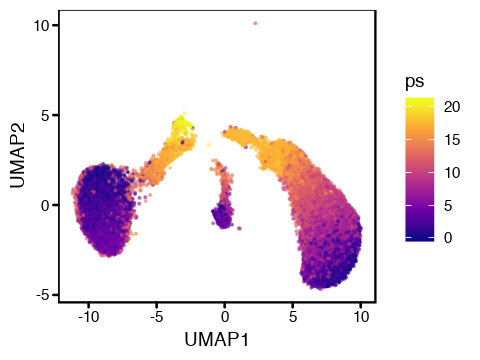

In [15]:
options(repr.plot.width = 4, repr.plot.height = 3)
# filter unkonwn
head(input.umap.res, 1)
dim(input.umap.res)
ggplot(output.motif.pt %>% select(UMAP1, UMAP2, ps) %>% distinct, aes(UMAP1, UMAP2)) + 
    geom_point(aes(color = ps), size = 0.1, alpha = 0.5) + scale_color_viridis_c(option='C') + 
    theme_pubr()
fn <- "../figures/Fig2/subfigs/fig2e.PS_UMAP_qc.pdf"
ggsave(fn, width = 4, height = 3, units = "in", useDingbats = F)
system(paste0("open ", fn))

### 1.4 filter motifs to only selected & smooth along the ps

In [17]:
dmotifs.list <- sapply(c("alpha", "beta", "delta"), function(x) fread("../figures/Fig2/subfigs/fig2_sub_vs_sub.volcation.motif_selection.csv") %>% 
    filter(selected & grepl(x, enrichedIn)) %>% pull(motif))
lapply(dmotifs.list, length)

$alpha
[1] 180

$beta
[1] 80

$delta
[1] 155

List of 7
 $ alpha:beta      : chr [1:2] "NRL" "Mafb"
 $ beta:delta      : chr [1:3] "TEAD1" "HNF1A" "HNF1B"
 $ alpha:delta     : chr [1:49] "STAT3" "Stat4" "FOXA1" "SNAI2" ...
 $ alpha:beta:delta: chr [1:73] "NEUROD1" "Rfx1" "TAL1::TCF3" "ASCL1" ...
 $ beta            : chr [1:2] "MAFG" "PBX2"
 $ alpha           : chr [1:56] "GATA2" "Gata4" "GATA3" "GATA6" ...
 $ delta           : chr [1:30] "Nkx3-1" "ISL2" "NKX3-2" "NFATC1" ...


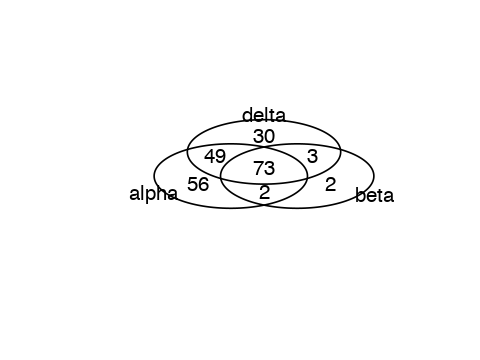

In [18]:
options(repr.plot.width = 4, repr.plot.height = 3)
tmp <- gplots::venn(dmotifs.list)
dmotifs.list.inter <- attr(tmp, "intersections")
dmotifs.list.inter %>% str


In [19]:
output.motif.pt %>% head(1)

cell,motif,zval,ps,celltype,UMAP1,UMAP2,cluster
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0765.1_ETV5,0.9046531,13.98913,alpha,-5.102393,1.38682,alpha_2


In [40]:
output.motif.pt <- output.motif.pt %>% separate(motif, c("jaspar", "motif"), sep = "_") %>% 
    select(motif, zval, ps, celltype) %>% rename(pt = "ps")
output.motif.pt %>% head(1)

motif,zval,pt,celltype
ETV5,0.9046531,13.98913,alpha


In [42]:
pt.max.list <- sapply(c("alpha", "beta", "delta"), function(ct) max((output.motif.pt %>% 
    filter(celltype == ct))$pt))
pt.max.list
pt.max.list[[ct]]

alpha     beta    delta 
20.85655 18.49255 14.97356

[1] 18.49255

In [44]:
fun.gamSmooth

function (tc, new.tps = seq(0, 20, by = 0.05)) 
{
    require(mgcv)
    tc.fit <- gam(zval ~ s(pt, bs = "cs"), data = tc)
    predict(tc.fit, newdata = data.frame(pt = new.tps))
}
<bytecode: 0x7ff7399af7a8>

In [45]:
pt.max <- pt.max.list[[ct]]
output.motif.pt.sub <- output.motif.pt %>% filter(celltype == ct)
output.motif.pt.sub%>%head(1)

motif,zval,pt,celltype
FOXA1,-0.5245952,17.5703,beta


In [47]:
system.time(smoothed.motif.pt <- do.call(rbind, lapply(c("alpha", "beta", "delta"), 
    function(ct) {
        pt.max <- pt.max.list[[ct]]
        output.motif.pt.sub <- output.motif.pt %>% filter(celltype == ct)
        
        do.call(rbind, mclapply(dmotifs.list[[ct]], function(x) {
            tc <- output.motif.pt.sub %>% filter(motif == x) %>% arrange(pt)
            data.frame(motif = x, ps = seq(0, pt.max, by = 0.05), zval = fun.gamSmooth(tc, 
                new.tps = seq(0, pt.max, by = 0.05)), celltype = ct)
        }, mc.cores = 6))
    })))

   user  system elapsed 
 31.203  15.770  13.809 

In [50]:
smoothed.motif.pt %>% head(5)
smoothed.motif.pt %>% nrow
lapply(c("alpha", "beta", "delta"), function(ct) smoothed.motif.pt %>% filter(celltype == 
    ct) %>% pull(motif) %>% unique %>% length)

motif,ps,zval,celltype
NEUROD1,0.00,0.8472072,alpha
NEUROD1,0.05,0.8259909,alpha
NEUROD1,0.10,0.8048418,alpha
NEUROD1,0.15,0.7838274,alpha
NEUROD1,0.20,0.7630147,alpha


[1] 151340

[[1]]
[1] 180

[[2]]
[1] 80

[[3]]
[1] 155

In [52]:
fwrite(smoothed.motif.pt, "../dat/1910_v2/smoothed.motif.pt.csv")